In [1]:
%autosave 0

Autosave disabled


In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import Holt, ExponentialSmoothing

Reading in our store data.

In [8]:
df = pd.read_csv('stores.csv', index_col=0)
df.head()

,sale_amount,item_brand,item_name,item_price,store_address,store_zipcode,store_city,store_state
sale_date,,,,,,,,
2013-01-01,13,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2013-01-02,11,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2013-01-03,14,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2013-01-04,13,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2013-01-05,10,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX


In [14]:
df['sales_total'] = df.sale_amount + df.item_price

In [15]:
df.index = pd.to_datetime(df.index)

Split before modeling. Human based split.

In [16]:
train = df.loc[:'2015']
validate = df.loc['2016']
test = df.loc['2017']

train.shape, validate.shape, test.shape

((547500, 9), (183000, 9), (182500, 9))

We need to perform an aggregation to have one point of the data per day. We can resample by the day and take the sum

In [17]:
day_train = train.resample('d').sales_total.sum()
day_val = validate.resample('d').sales_total.sum()
day_test = test.resample('d').sales_total.sum()

day_train.head()

sale_date
2013-01-01    16276.2
2013-01-02    16258.2
2013-01-03    17068.2
2013-01-04    18257.2
2013-01-05    18817.2
Freq: D, Name: sales_total, dtype: float64

Visualize

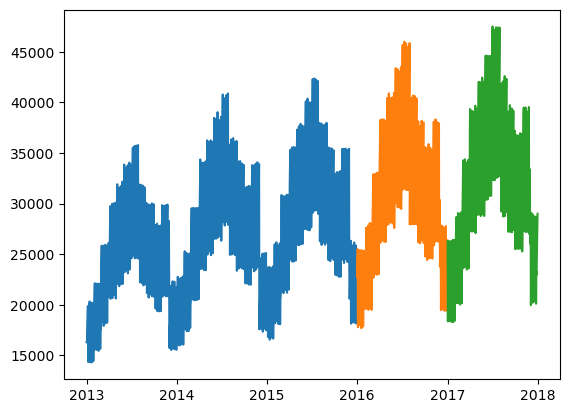

In [18]:
plt.plot(day_train)
plt.plot(day_val)
plt.plot(day_test)
plt.show()

Now that our data is properly split, let's try two different modeling approaches:
- One baseline model (rolling average)
- One non-baseline model (Holt's seasonal trend)

In [19]:
rolling = round(day_train.rolling(30).mean()[-1], 2)
rolling

22232.07

In [20]:
preds = pd.DataFrame({'actual': day_val,
                      'rolling': rolling})

preds.head()

,actual,rolling
sale_date,,
2016-01-01,22738.2,22232.07
2016-01-02,23860.2,22232.07
2016-01-03,25491.2,22232.07
2016-01-04,17779.2,22232.07
2016-01-05,20386.2,22232.07


Defining a simple function to evaluate our models

In [23]:
def eval_preds(df, predictions, actual='actual'):
    
    return round(sqrt(mean_squared_error(df[actual], df[predictions])), 2)

In [24]:
eval_preds(preds, 'rolling')

10689.53

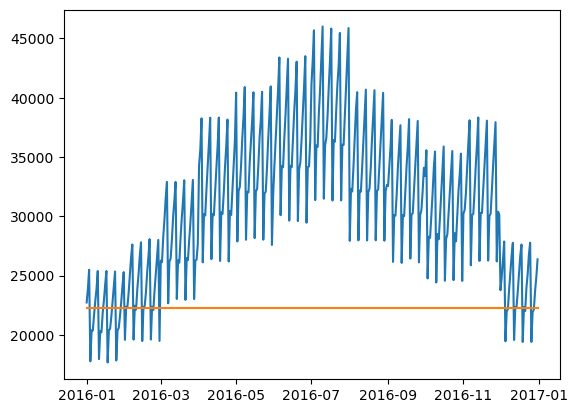

In [25]:
plt.plot(preds['actual'])
plt.plot(preds['rolling'])
plt.plot(preds['hy_rolling'])
plt.show()

Thing I passed into my model:
- Train dataset
- The number of observations before the seasonality repeats(365)
- The type of trend in my dataset (it's additive)
- Seasonality is also set to additive

Finally at the end I am calling the .fit() method on my model

In [26]:
hst_model = ExponentialSmoothing(day_train, seasonal_periods=365, trend='add', seasonal='add').fit()

/usr/local/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


When I am calling the .forecast() methos on my model object, I specify hoe many observations to produce. In this case, I am asking for a nukber of observations equal to the days in the validate dataset

In [28]:
hst_model.forecast(day_val.shape[0])

2016-01-01    21201.955751
2016-01-02    22679.673499
2016-01-03    23567.776116
2016-01-04    24930.136389
2016-01-05    22008.880257
                  ...     
2016-12-27    27475.615122
2016-12-28    24023.773784
2016-12-29    22197.064240
2016-12-30    23149.564663
2016-12-31    23395.528138
Freq: D, Length: 366, dtype: float64

In [29]:
preds['hst'] = hst_model.forecast(day_val.shape[0])

I see that my model outperformed the baseline

In [30]:
eval_preds(preds, 'hst')

4822.66

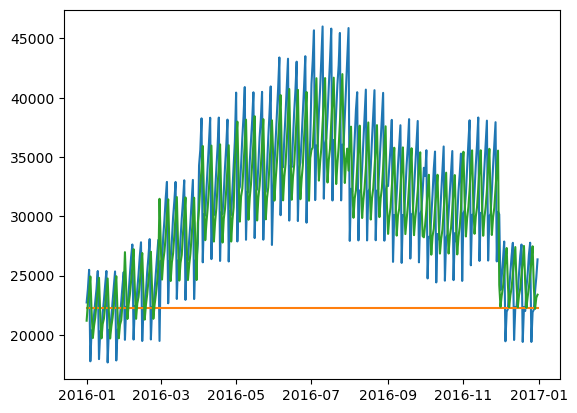

In [31]:
plt.plot(preds['actual'])
plt.plot(preds['rolling'])
plt.plot(preds['hst'])
plt.show()